# Learn to Play Tic-toc-toe

The goal of this assignment is to make your RL agent learn to play tic-toc-toe using tabular RL methods and compare the methods in the process.

## Task 1: Describe your MDP (2 marks)

Design your MDP for this problem.
- Mention what are your states and how are the states represented.
- Mention the dynamics of your reward function

To solve the Tic-tac-toe problem using Reinforcement Learning (RL), we'll first need to describe the Markov Decision Process (MDP). The MDP consists of states, actions, rewards, and transitions. Below is a breakdown of each element as it pertains to Tic-tac-toe:

**State Representation :**

Each state represents a specific configuration of the Tic-tac-toe board.
The board consists of 9 cells, and each cell can be in one of three states: empty `(0)`, occupied by player `1 (1)`, or occupied by player `2 (2)`.
Therefore, the state space can be represented as a 9-tuple, where each element of the tuple corresponds to a cell in the Tic-tac-toe grid. For example, a state can be represented as `(1, 0, 2, 0, 1, 2, 0, 0, 1)`.
So, number of Possible States are $3^9$. However, not all of these states are valid because some would represent an impossible number of moves by one player. Thus, the actual number of valid states is smaller.

**Action Representation :**

An action corresponds to placing a marker (either `1` for player `1` or `2` for player `2`) in any empty cell on the board. Each action can be represented by the index of the cell where the marker is placed (ranging from `0` to `8` for the `9` cells on the board).

**Reward Function :**

*Winning:* If a player places a marker that results in a win (three of their markers in a row, column, or diagonal), the agent receives a positive reward, e.g., `+1`.
*Losing:* If the opponent wins, the agent receives a negative reward, e.g., `-1`.
*Draw:* If the board is full and no player has won, the agent receives a neutral reward, e.g., `0`.
*Invalid Move:* If the agent tries to make an invalid move (e.g., placing a marker in an already occupied cell), it could receive a high negative reward, or the move might not be allowed.

**Transition Dynamics :**

After the agent takes an action (places a marker), the state transitions to a new state based on the current state and the action taken.
The game then checks if the game has ended (win, lose, or draw). If not, the opponent (either another agent or a human player) takes a turn, further transitioning the state.The game alternates between players until a terminal state (win, lose, or draw) is reached.

## Task 2: Implement your agent using Monte Carlo (4 marks)

Given any situation on the board, your agent should take an action. After your agent takes an action, the opponent (which can also be another instance of one of your agents) also takes an action. Your agent learns based on what happened.

For a cleaner implementation, you may consider having an abstract class to define the framework and implement specific RL methods in subclasses.

In this task, your agent should learn using Monte-Carlo method.

In [2]:
from abc import ABC, abstractmethod
import random
import numpy as np

class TicTacToeAgent(ABC):
    def __init__(self, player, epsilon=0.3):
        self.player = player  # 1 for 'X', 2 for 'O'
        self.epsilon = epsilon  # For exploration-exploitation trade-off
        self.state_values = {}  # Dictionary to store value of each state

    @abstractmethod
    def choose_action(self, state):
        pass

    @abstractmethod
    def update_value_function(self, state, reward):
        pass

    def get_available_actions(self, state):
        # Return the indices of empty cells
        return [i for i, cell in enumerate(state) if cell == 0]

    def get_state_hash(self, state):
        # Convert the board state to a tuple to be used as a key in a dictionary
        return tuple(state)

    def update_state_values(self, state, value):
        # Updates the value of a given state
        state_hash = self.get_state_hash(state)
        if state_hash not in self.state_values:
            self.state_values[state_hash] = value
        else:
            self.state_values[state_hash] += value

class MonteCarloAgent(TicTacToeAgent):
    def __init__(self, player, epsilon=0.3, discount_factor=1.0):
        super().__init__(player, epsilon)
        self.discount_factor = discount_factor  # Discount factor for future rewards
        self.returns = {}  # To store returns for each state-action pair

    def choose_action(self, state, test=False):
        available_actions = self.get_available_actions(state)

        if not test :
          # Epsilon-greedy policy for action selection
          if random.uniform(0, 1) < self.epsilon:
              # Exploration: choose a random action
              return random.choice(available_actions)
          else:
              # Exploitation: choose the best action based on state values
              best_action = None
              best_value = -float('inf')
              for action in available_actions:
                  next_state = state[:]
                  next_state[action] = self.player
                  state_hash = self.get_state_hash(next_state)
                  state_value = self.state_values.get(state_hash, 0)
                  if state_value > best_value:
                      best_value = state_value
                      best_action = action
              return best_action
        else :
            best_action = None
            best_value = -float('inf')
            for action in available_actions:
                next_state = state[:]
                next_state[action] = self.player
                state_hash = self.get_state_hash(next_state)
                state_value = self.state_values.get(state_hash, 0)
                if state_value > best_value:
                    best_value = state_value
                    best_action = action
            return best_action


    def update_value_function(self, episode):
        # Calculate the returns for each state-action pair and update state values
        G = 0  # Initialize the return
        for state, reward in reversed(episode):
            G = self.discount_factor * G + reward
            state_hash = self.get_state_hash(state)
            if state_hash not in self.returns:
                self.returns[state_hash] = []
            self.returns[state_hash].append(G)
            self.state_values[state_hash] = np.mean(self.returns[state_hash])

    def play_episode(self, opponent):
        # Simulate an entire game (episode)
        state = [0] * 9  # Start with an empty board
        episode = []
        result = 0

        while True:
            # Agent takes an action
            action = self.choose_action(state)
            state[action] = self.player
            episode.append((state[:], 0))  # Reward is 0 until the game ends

            # Check if the agent has won
            if self.check_winner(state, self.player):
                episode[-1] = (state[:], 1)  # Update the reward for winning
                result = 1
                break

            # Check for a draw
            if 0 not in state:
                episode[-1] = (state[:], 0)  # Update the reward for a draw
                break

            # Opponent takes an action
            opp_action = opponent.choose_action(state)
            state[opp_action] = 3 - self.player

            # Check if the opponent has won
            if self.check_winner(state, 3 - self.player):
                episode[-1] = (state[:], -1)  # Update the reward for losing
                result = -1
                break

        # Update the value function based on the episode
        self.update_value_function(episode)
        return result

    def check_winner(self, state, player):
        # Check all winning combinations
        winning_combinations = [(0, 1, 2), (3, 4, 5), (6, 7, 8),
                                (0, 3, 6), (1, 4, 7), (2, 5, 8),
                                (0, 4, 8), (2, 4, 6)]
        for combo in winning_combinations:
            if state[combo[0]] == state[combo[1]] == state[combo[2]] == player:
                return True
        return False

In [3]:
agent1 = MonteCarloAgent(player=1)
agent2 = MonteCarloAgent(player=2)

num_episodes = 10000
for _ in range(num_episodes):
    agent1.play_episode(opponent=agent2)
    agent2.play_episode(opponent=agent1)

In [4]:
# Play against human to check
import random

def play_against_human(agent):
    def print_board(state):
        board_symbols = {0: " ", 1: "X", 2: "O"}
        print("\nBoard:")
        print(f"{board_symbols[state[0]]} | {board_symbols[state[1]]} | {board_symbols[state[2]]}")
        print("--+---+--")
        print(f"{board_symbols[state[3]]} | {board_symbols[state[4]]} | {board_symbols[state[5]]}")
        print("--+---+--")
        print(f"{board_symbols[state[6]]} | {board_symbols[state[7]]} | {board_symbols[state[8]]}")
        print("\n")

    state = [0] * 9  # Start with an empty board
    turn = random.choice([1, 2])  # Randomly select who goes first (1: agent, 2: human)

    if turn == agent.player:
        print(f"\nAgent goes first")
    else:
        print(f"\nYou go first")

    while True:
        if turn == agent.player:
            action = agent.choose_action(state, test=True)
            state[action] = agent.player
            print(f"Agent plays at position {action + 1}")
        else:
            # print_board(state)
            human_action = int(input("Your move (1-9): ")) - 1
            while state[human_action] != 0:
                human_action = int(input("Invalid move. Choose an empty cell (1-9): ")) - 1
            state[human_action] = 3 - agent.player

        print_board(state)

        if agent.check_winner(state, agent.player):
            print("Agent wins!")
            break
        elif agent.check_winner(state, 3 - agent.player):
            print("You win!")
            break
        elif 0 not in state:
            print("It's a draw!")
            break

        turn = 3 - turn  # Switch turns

In [5]:
# Play multiple games against a human
while(True):
  if input("Want to play more ? (Y/N)")=="N":
    break
  play_against_human(agent1)

Want to play more ? (Y/N)Y

Agent goes first
Agent plays at position 3

Board:
  |   | X
--+---+--
  |   |  
--+---+--
  |   |  


Your move (1-9): 1

Board:
O |   | X
--+---+--
  |   |  
--+---+--
  |   |  


Agent plays at position 9

Board:
O |   | X
--+---+--
  |   |  
--+---+--
  |   | X


Your move (1-9): 6

Board:
O |   | X
--+---+--
  |   | O
--+---+--
  |   | X


Agent plays at position 7

Board:
O |   | X
--+---+--
  |   | O
--+---+--
X |   | X


Your move (1-9): 5

Board:
O |   | X
--+---+--
  | O | O
--+---+--
X |   | X


Agent plays at position 8

Board:
O |   | X
--+---+--
  | O | O
--+---+--
X | X | X


Agent wins!
Want to play more ? (Y/N)N


## Task 3: Implement your agent using Q-Learning (4 marks)

Implement same as Task 2 using Q-learning.

In [6]:
import random
import numpy as np

class QLearningAgent(TicTacToeAgent):
    def __init__(self, player, epsilon=0.1, alpha=0.5, gamma=0.9):
        super().__init__(player, epsilon)
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.q_table = {}  # Initialize the Q-table as a dictionary

    def choose_action(self, state, test=False):
        available_actions = self.get_available_actions(state)
        state_hash = self.get_state_hash(state)

        if not test:
          # Epsilon-greedy policy for action selection
          if random.uniform(0, 1) < self.epsilon:
              # Exploration: choose a random action
              return random.choice(available_actions)
          else:
              # Exploitation: choose the action with the highest Q-value
              q_values = [self.q_table.get((state_hash, action), 0) for action in available_actions]
              max_q_value = max(q_values)
              # In case of ties, randomly select among the best actions
              best_actions = [action for action, q_value in zip(available_actions, q_values) if q_value == max_q_value]
              return random.choice(best_actions)
        else :
              q_values = [self.q_table.get((state_hash, action), 0) for action in available_actions]
              max_q_value = max(q_values)
              # In case of ties, randomly select among the best actions
              best_actions = [action for action, q_value in zip(available_actions, q_values) if q_value == max_q_value]
              return random.choice(best_actions)

    def update_value_function(self, state, action, reward, next_state):
        state_hash = self.get_state_hash(state)
        next_state_hash = self.get_state_hash(next_state)

        # Current Q-value
        current_q = self.q_table.get((state_hash, action), 0)

        # Max Q-value for the next state
        available_actions = self.get_available_actions(next_state)
        next_max_q = max([self.q_table.get((next_state_hash, next_action), 0) for next_action in available_actions], default=0)

        # Q-learning update
        new_q = current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
        self.q_table[(state_hash, action)] = new_q

    def play_episode(self, opponent):
        state = [0] * 9  # Start with an empty board
        result = 0

        while True:
            # Agent takes an action
            action = self.choose_action(state)
            next_state = state.copy()
            next_state[action] = self.player

            # Check if the agent has won
            if self.check_winner(next_state, self.player):
                self.update_value_function(state, action, 1, next_state)  # Reward for winning
                result = 1
                break

            # Check for a draw
            if 0 not in next_state:
                self.update_value_function(state, action, 0, next_state)  # Reward for a draw
                break

            # Opponent takes an action
            opp_action = opponent.choose_action(next_state)
            next_state[opp_action] = 3 - self.player

            # Check if the opponent has won
            if self.check_winner(next_state, 3 - self.player):
                self.update_value_function(state, action, -1, next_state)  # Penalty for losing
                result = -1
                break

            # Update Q-value for the agent's action with the transition to the next state
            self.update_value_function(state, action, 0, next_state)

            # Update state
            state = next_state
        return result

    def check_winner(self, state, player):
        # Check all winning combinations
        winning_combinations = [(0, 1, 2), (3, 4, 5), (6, 7, 8),
                                (0, 3, 6), (1, 4, 7), (2, 5, 8),
                                (0, 4, 8), (2, 4, 6)]
        for combo in winning_combinations:
            if state[combo[0]] == state[combo[1]] == state[combo[2]] == player:
                return True
        return False

In [9]:
agent1 = QLearningAgent(player=1)
agent2 = QLearningAgent(player=2)

# Train the agent
num_training_episodes = 10000
for _ in range(num_training_episodes):
    agent1.play_episode(opponent=agent2)
    agent2.play_episode(opponent=agent1)

# Play multiple games against a human
while(True):
  if input("Want to play more ? (Y/N)")=="N":
    break
  play_against_human(agent1)

Want to play more ? (Y/N)Y

Agent goes first
Agent plays at position 6

Board:
  |   |  
--+---+--
  |   | X
--+---+--
  |   |  


Your move (1-9): 5

Board:
  |   |  
--+---+--
  | O | X
--+---+--
  |   |  


Agent plays at position 3

Board:
  |   | X
--+---+--
  | O | X
--+---+--
  |   |  


Your move (1-9): 9

Board:
  |   | X
--+---+--
  | O | X
--+---+--
  |   | O


Agent plays at position 1

Board:
X |   | X
--+---+--
  | O | X
--+---+--
  |   | O


Your move (1-9): 2

Board:
X | O | X
--+---+--
  | O | X
--+---+--
  |   | O


Agent plays at position 8

Board:
X | O | X
--+---+--
  | O | X
--+---+--
  | X | O


Your move (1-9): 7

Board:
X | O | X
--+---+--
  | O | X
--+---+--
O | X | O


Agent plays at position 4

Board:
X | O | X
--+---+--
X | O | X
--+---+--
O | X | O


It's a draw!
Want to play more ? (Y/N)N


## Task 4: Compare the two methods (4 marks)

Use any good implementation of the minimax algorithm typically used for the tic-toc-toe game as the opponent. Note that the algorithm is optimal, so it may never lose. Modify that algorithm to take random available actions $\epsilon$ fraction of the times so that your agent can learn. Choose a suitable $\epsilon$, too small may not be a good idea.

Compare how fast your Monte-Carlo and Q-Learning implementations learn against the modified minimax algorithm. Use suitable plots.

In [11]:
class MinimaxOpponent:
    def __init__(self, player):
        self.player = player
        self.opponent = 3 - player

    def isMovesLeft(self, board):
        return 0 in board

    def evaluate(self, board):
        # Convert 1D board to 2D board for evaluation
        b = [board[i:i+3] for i in range(0, 9, 3)]

        # Checking for Rows for X or O victory.
        for row in range(3):
            if b[row][0] == b[row][1] == b[row][2]:
                if b[row][0] == self.player:
                    return 10
                elif b[row][0] == self.opponent:
                    return -10

        # Checking for Columns for X or O victory.
        for col in range(3):
            if b[0][col] == b[1][col] == b[2][col]:
                if b[0][col] == self.player:
                    return 10
                elif b[0][col] == self.opponent:
                    return -10

        # Checking for Diagonals for X or O victory.
        if b[0][0] == b[1][1] == b[2][2]:
            if b[0][0] == self.player:
                return 10
            elif b[0][0] == self.opponent:
                return -10

        if b[0][2] == b[1][1] == b[2][0]:
            if b[0][2] == self.player:
                return 10
            elif b[0][2] == self.opponent:
                return -10

        # Else if none of them have won then return 0
        return 0

    def minimax(self, board, depth, isMax):
        score = self.evaluate(board)

        # If Maximizer has won the game return his/her evaluated score
        if score == 10:
            return score

        # If Minimizer has won the game return his/her evaluated score
        if score == -10:
            return score

        # If there are no more moves and no winner then it is a tie
        if not self.isMovesLeft(board):
            return 0

        # If this maximizer's move
        if isMax:
            best = -1000
            for i in range(9):
                if board[i] == 0:
                    board[i] = self.player
                    best = max(best, self.minimax(board, depth + 1, not isMax))
                    board[i] = 0
            return best
        else:
            best = 1000
            for i in range(9):
                if board[i] == 0:
                    board[i] = self.opponent
                    best = min(best, self.minimax(board, depth + 1, not isMax))
                    board[i] = 0
            return best

    def findBestMove(self, board):
        bestVal = -1000
        bestMove = -1

        for i in range(9):
            if board[i] == 0:
                board[i] = self.player
                moveVal = self.minimax(board, 0, False)
                board[i] = 0
                if moveVal > bestVal:
                    bestMove = i
                    bestVal = moveVal
        return bestMove

    def choose_action(self, board):
        return self.findBestMove(board)

    def play_against_human(self):
        board = [0] * 9
        current_player = self.player

        while True:
            self.display_board(board)

            if current_player == self.player:
                print("Minimax's turn:")
                move = self.choose_action(board)
                print(f"Minimax chooses move: {move}")
            else:
                print("Your turn:")
                move = self.get_human_move(board)

            # Make the move
            board[move] = current_player

            # Check for a winner or a tie
            if self.evaluate(board) == 10:
                self.display_board(board)
                print("Minimax wins!")
                break
            elif self.evaluate(board) == -10:
                self.display_board(board)
                print("You win!")
                break
            elif not self.isMovesLeft(board):
                self.display_board(board)
                print("It's a tie!")
                break

            # Switch players
            current_player = 3 - current_player

    def display_board(self, board):
        b = [board[i:i+3] for i in range(0, 9, 3)]
        print("Board:")
        for row in b:
            print(" ".join(self.convert_cell(cell) for cell in row))
        print()

    def convert_cell(self, cell):
        if cell == 0:
            return '.'
        elif cell == self.player:
            return 'X'
        elif cell == self.opponent:
            return 'O'
        return ' '

    def get_human_move(self, board):
        while True:
            try:
                move = int(input("Enter your move (0-8): "))
                if 0 <= move < 9 and board[move] == 0:
                    return move
                else:
                    print("Invalid move. Try again.")
            except ValueError:
                print("Invalid input. Please enter a number between 0 and 8.")

In [12]:
# Example usage of the MinimaxOpponent class to play against a human

# Initialize the Minimax opponent
player = 1  # Player 1 (X) will be controlled by Minimax
minimax_opponent = MinimaxOpponent(player=player)

# Start the game against a human
minimax_opponent.play_against_human()

Board:
. . .
. . .
. . .

Minimax's turn:
Minimax chooses move: 0
Board:
X . .
. . .
. . .

Your turn:
Enter your move (0-8): 5
Board:
X . .
. . O
. . .

Minimax's turn:
Minimax chooses move: 2
Board:
X . X
. . O
. . .

Your turn:
Enter your move (0-8): 1
Board:
X O X
. . O
. . .

Minimax's turn:
Minimax chooses move: 4
Board:
X O X
. X O
. . .

Your turn:
Enter your move (0-8): 6
Board:
X O X
. X O
O . .

Minimax's turn:
Minimax chooses move: 8
Board:
X O X
. X O
O . X

Minimax wins!


In [13]:
# Initialize agents
from tqdm import tqdm
minimax_opponent = MinimaxOpponent(player=2)
mc_agent = MonteCarloAgent(player=1)
ql_agent = QLearningAgent(player=1)

# Training and Evaluation
def train_and_evaluate(num_episodes, first_agent, minimax_opponent):
    mc_lose = 0
    win_percentages = []

    for episode in tqdm(range(num_episodes)):
        # Train Monte Carlo agent against Minimax opponent
        first_agent.play_episode(minimax_opponent)

        # Update results
        if first_agent.play_episode(minimax_opponent) == -1:
            mc_lose += 1

        # Calculate win percentage
        win_percentage = mc_lose * 100 / (episode + 1)
        win_percentages.append(win_percentage)

    return win_percentages

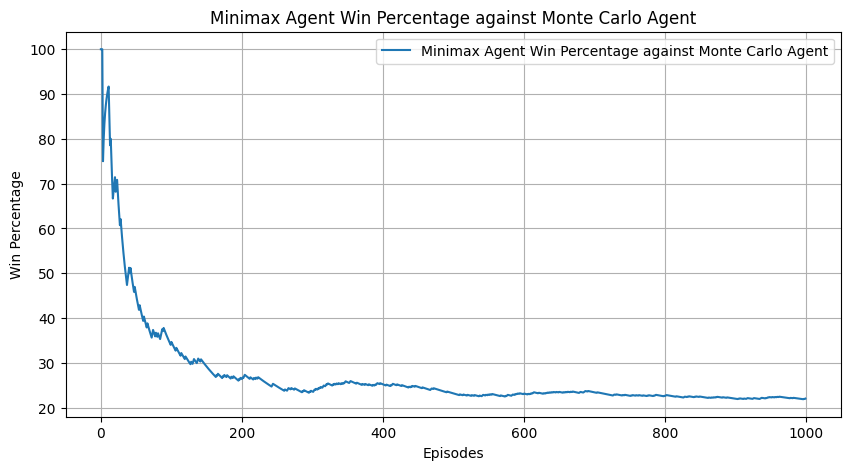

In [15]:
# Train the agent
import matplotlib.pyplot as plt
num_episodes = 1000
win_percentages = train_and_evaluate(num_episodes, mc_agent, minimax_opponent)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(num_episodes), win_percentages, label='Minimax Agent Win Percentage against Monte Carlo Agent')
plt.xlabel('Episodes')
plt.ylabel('Win Percentage')
plt.title('Minimax Agent Win Percentage against Monte Carlo Agent')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 1000/1000 [07:46<00:00,  2.14it/s]


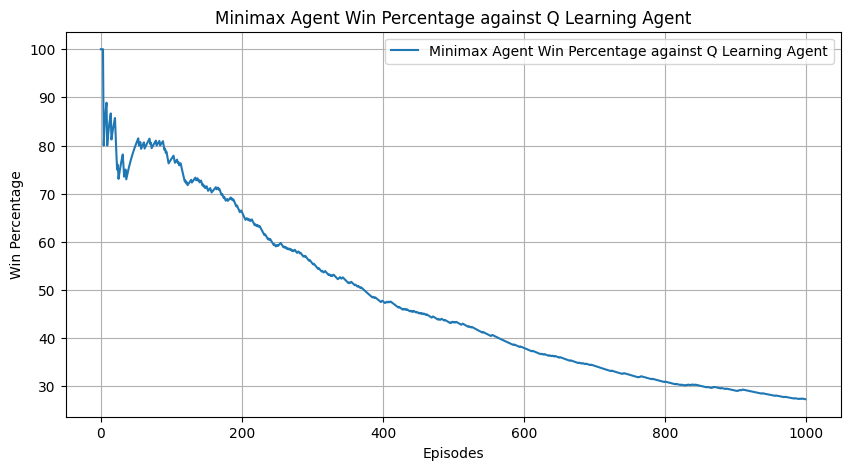

In [16]:
win_percentages = train_and_evaluate(num_episodes, ql_agent, minimax_opponent)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(range(num_episodes), win_percentages, label='Minimax Agent Win Percentage against Q Learning Agent')
plt.xlabel('Episodes')
plt.ylabel('Win Percentage')
plt.title('Minimax Agent Win Percentage against Q Learning Agent')
plt.legend()
plt.grid(True)
plt.show()

## Task 5: Let the two agents play against each other (4 marks)

Initialize both agents in the same way and let them play against each other and learn. Evaluate whether one agent learns to win quicker than the other. Does the other agent catch up eventually? Use suitable plots.

In [18]:
mc_agent = MonteCarloAgent(player=1)
ql_agent = QLearningAgent(player=2)
mc_reward = 0
q1_reward = 0
cum_reward_mc = []
cum_reward_ql = []
num_episodes = 10000

for episode in tqdm(range(num_episodes)):

  res1 , res2 = mc_agent.play_episode(ql_agent), ql_agent.play_episode(mc_agent)
  mc_reward += res1
  q1_reward += res2

  cum_reward_mc.append(mc_reward)
  cum_reward_ql.append(q1_reward)

100%|██████████| 10000/10000 [00:06<00:00, 1478.44it/s]


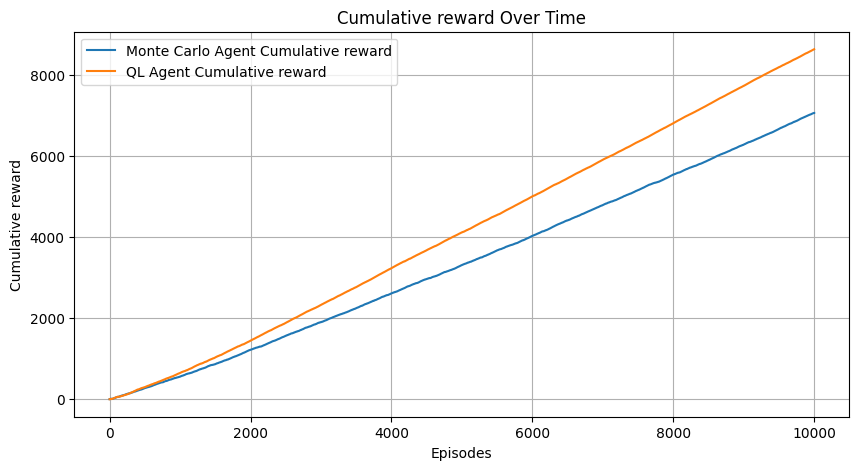

In [19]:
# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(num_episodes), cum_reward_mc, label='Monte Carlo Agent Cumulative reward')
plt.plot(range(num_episodes), cum_reward_ql, label='QL Agent Cumulative reward')
plt.xlabel('Episodes')
plt.ylabel('Cumulative reward')
plt.title('Cumulative reward Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Task 6: Identify winning positions (2 marks)

Once your agents have learnt optimal policies, they are good enough to force wins from certain situations of the board. Obviously, if the board is almost finished (most boxes ticked), such situations are more common. But what are the positions of the board with minimal number of moves played from which one player can force a win, no matter what the opponent does? Identify such situations using functions that your agent has learnt.

In [26]:
def can_force_win_with_policy(agent, board, player_id):
    # Get available actions
    available_moves = get_available_actions(board)

    # Simulate each available move for the current player based on the agent's learned policy
    for move in available_moves:
        board_copy = board[:]
        board_copy[move] = player_id  # Simulate the player's move

        # If the move results in a win, the player can force a win
        if check_win(board_copy, player_id):
            return True

        # Use the agent's policy to choose the best action for the opponent
        opponent_id = 3 - player_id  # Switch to the opponent
        opponent_move = agent.choose_action(board_copy, opponent_id)

        # Simulate the opponent's best move
        if opponent_move in get_available_actions(board_copy):
            board_copy[opponent_move] = opponent_id
            if check_win(board_copy, opponent_id):
                # Opponent can win, so it's not a forced win for the player
                return False

        # If no winning move for the opponent, the player can force a win
        return True

    return False


def find_minimal_winning_positions(agent, player_id):
    minimal_winning_positions = []

    # Iterate through all possible board configurations (3^9 possible states for a 3x3 Tic-Tac-Toe board)
    for i in range(3 ** 9):
        board = [int(x) for x in np.base_repr(i, base=3).zfill(9)]

        # Skip board configurations where the game is already won by any player
        if check_win(board, 1) or check_win(board, 2):
            continue

        # Check if the current player can force a win from this position
        if can_force_win_with_policy(agent, board, player_id):
            minimal_winning_positions.append(board)

    return minimal_winning_positions

def check_win(board, player_id):
    # Define winning combinations
    wins = [
        [0, 1, 2], [3, 4, 5], [6, 7, 8],  # Rows
        [0, 3, 6], [1, 4, 7], [2, 5, 8],  # Columns
        [0, 4, 8], [2, 4, 6]              # Diagonals
    ]
    for win in wins:
        if all(board[i] == player_id for i in win):
            return True
    return False

def get_available_actions(board):
    return [i for i, x in enumerate(board) if x == 0]

def print_board(board):
    symbols = {0: " ", 1: "X", 2: "O"}  # Mapping numbers to symbols (X for player 1, O for player 2, and " " for empty)

    print("Board:")
    for i in range(3):
        row = [symbols[board[j]] for j in range(i * 3, (i + 1) * 3)]
        print(" | ".join(row))
        if i < 2:
            print("-" * 9)  # Add a separator between rows
    print()  # Extra newline for spacing

player_id = 1  # Player for whom we want to find forced wins
minimal_winning_positions = find_minimal_winning_positions(mc_agent, player_id)

# Print results
for pos in minimal_winning_positions:
    print(f"Player X can force a win from board state:")
    print_board(pos)

Streaming output truncated to the last 5000 lines.
Player X can force a win from board state:
Board:
O | X | O
---------
X | X |  
---------
X | O | O

Player X can force a win from board state:
Board:
O | X | O
---------
X | X |  
---------
O |   |  

Player X can force a win from board state:
Board:
O | X | O
---------
X | X |  
---------
O |   | X

Player X can force a win from board state:
Board:
O | X | O
---------
X | X |  
---------
O |   | O

Player X can force a win from board state:
Board:
O | X | O
---------
X | X |  
---------
O | O |  

Player X can force a win from board state:
Board:
O | X | O
---------
X | X |  
---------
O | O | X

Player X can force a win from board state:
Board:
O | X | O
---------
X | X | O
---------
  |   |  

Player X can force a win from board state:
Board:
O | X | O
---------
X | X | O
---------
  |   | X

Player X can force a win from board state:
Board:
O | X | O
---------
X | X | O
---------
  | O | X

Player X can force a win from board stat